INFO:absl:Load dataset info from ../../../../../local_data/tfds/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (../../../../../local_data/tfds/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], from ../../../../../local_data/tfds/mnist/3.0.1
2025-07-07 14:00:44.274452: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Number of training samples: 48000
Number of validation samples: 6000
Number of test samples: 6000


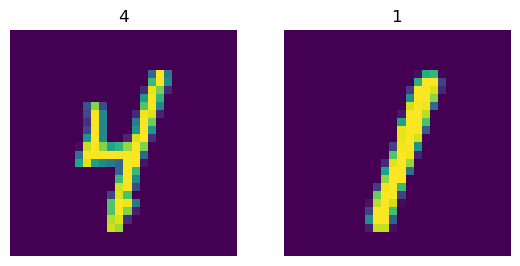

In [ ]:
# based on https://keras.io/guides/transfer_learning/ by fchollett

import numpy as np
import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import logging, os

logging.basicConfig(level=logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"mnist_transfer/"
os.system("mkdir -p " + OUTPUT_PATH)

(train_ds, validation_ds, test_ds), metadata = tfds.load(
        'mnist',
        # 'cifar10',
        # 'tf_flowers',
        # 'cats_vs_dogs',
        data_dir=DATA_PATH,
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        with_info=True,
        as_supervised=True,
)
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(2)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [37]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [38]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [39]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(np.expand_dims(first_image, 0))
#         plt.imshow(np.array(augmented_image[0]).astype("int32"))
#         plt.title(int(labels[0]))
#         plt.axis("off")

In [40]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_12[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [41]:
# Freeze the base_model
base_model.trainable = False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_12[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [42]:

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
scale_layer = keras.layers.Rescaling(scale=1 / 255.0, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d_5  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_5 (Dropout)         (None, 2048)              0   

In [43]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

# model.fit(
#     train_ds,
#     epochs=1,
#     validation_data=validation_ds,
# )

Fitting the top layer of the model
Epoch 1/2


ValueError: in user code:

    File "/home/tmeng12/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/tmeng12/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tmeng12/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/tmeng12/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/tmeng12/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/tmeng12/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'xception' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 150, 150, 1)
    
    Call arguments received by layer 'xception' (type Functional):
      • inputs=tf.Tensor(shape=(None, 150, 150, 1), dtype=float32)
      • training=False
      • mask=None
